In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from datetime import datetime

tqdm.pandas()

In [ ]:
sent_df = pd.read_csv(r"C:\Stock\historical_news_hdfc_bank_filtered.csv")

sent_df = sent_df[(sent_df['language'] == 'English')]
sent_df['date'] = pd.to_datetime(sent_df['date'], format='%Y%m%dT%H%M%SZ', errors='coerce')
sent_df = sent_df.dropna(subset=['date'])
sent_df = sent_df[['date', 'title', 'category']]
print("Cleaned sentiment rows:", len(sent_df))
print(sent_df.shape)
print(sent_df.columns)
sent_df.head()

Cleaned sentiment rows: 18960
(18960, 3)
Index(['date', 'title', 'category'], dtype='object')


,date,title,category
0,2023-04-28 02:45:00,RBI looking at bank business models to spot vu...,sector
1,2023-04-28 03:00:00,"After decade of wilderness , Indian banking se...",company
2,2023-04-28 04:30:00,"Share Market Today LIVE | Sensex , Nifty , BSE...",sector
3,2023-04-28 04:45:00,Axis Bank Q4 FY23 – decent show masked by Citi...,sector
4,2023-04-28 04:45:00,Brokerages forecast 6 . 7 % rise in Kotak Mahi...,sector


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def get_finbert_sentiment(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {"positive": 0.0, "neutral": 0.0, "negative": 0.0, "compound": 0.0}

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # FinBERT label order: [negative, neutral, positive]
    probs = probs[0].cpu().numpy()
    neg, neu, pos = probs
    compound = pos - neg  # net sentiment

    return {
        "positive": float(pos),
        "neutral": float(neu),
        "negative": float(neg),
        "compound": float(compound)
    }
# Apply FinBERT sentiment extraction
results = sent_df['title'].progress_apply(get_finbert_sentiment)

# Convert list of dicts into DataFrame columns
sent_scores = pd.DataFrame(results.tolist())

# Merge back with original
sent_df = pd.concat([sent_df.reset_index(drop=True), sent_scores], axis=1)

sent_df.head()

C:\Users\jhanv\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jhanv\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\jhanv\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jhanv\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more s

,date,title,category,positive,neutral,negative,compound
0,2023-04-28 02:45:00,RBI looking at bank business models to spot vu...,sector,0.925592,0.019805,0.054603,0.870989
1,2023-04-28 03:00:00,"After decade of wilderness , Indian banking se...",company,0.048822,0.088806,0.862372,-0.813549
2,2023-04-28 04:30:00,"Share Market Today LIVE | Sensex , Nifty , BSE...",sector,0.933133,0.031156,0.035710,0.897423
3,2023-04-28 04:45:00,Axis Bank Q4 FY23 – decent show masked by Citi...,sector,0.325818,0.107025,0.567157,-0.241339
4,2023-04-28 04:45:00,Brokerages forecast 6 . 7 % rise in Kotak Mahi...,sector,0.030576,0.022113,0.947312,-0.916736


In [ ]:
save_directory = "./finbert_finetuned"

# Save model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f" Model and tokenizer saved to {save_directory}")

✅ Model and tokenizer saved to ./finbert_finetuned


In [ ]:
!pip install ipywidgets

from huggingface_hub import login
login() 


   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ---------------------------------------- 914.9/914.9 kB 8.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 15.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
model.push_to_hub("JhanviN/finbert-sentiment-custom", private=False)
tokenizer.push_to_hub("JhanviN/finbert-sentiment-custom", private=False)


model.safetensors: 100%|████████████████████████████████████████████████████████████| 438M/438M [00:33<00:00, 13.1MB/s]
C:\Users\jhanv\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jhanv\.cache\huggingface\hub\models--JhanviN--finbert-sentiment-custom. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-fo

CommitInfo(commit_url='https://huggingface.co/JhanviN/finbert-sentiment-custom/commit/b150cb3f2846c68111ae3f92e8d916a5b4d80e72', commit_message='Upload tokenizer', commit_description='', oid='b150cb3f2846c68111ae3f92e8d916a5b4d80e72', pr_url=None, repo_url=RepoUrl('https://huggingface.co/JhanviN/finbert-sentiment-custom', endpoint='https://huggingface.co', repo_type='model', repo_id='JhanviN/finbert-sentiment-custom'), pr_revision=None, pr_num=None)

In [34]:
sent_df['date'] = pd.to_datetime(sent_df['date'], format='%Y%m%dT%H%M%SZ')
sent_df['date'] = sent_df['date'].dt.date
sent_df['date']

# group by date and category
daily_sent = (
    sent_df.groupby(['date', 'category'])[['compound']]
    .mean()
    .reset_index()
    .pivot(index='date', columns='category', values='compound')
    .fillna(0)
    .reset_index()
)


In [35]:
decay_factor = 0.68  # can be tuned

def apply_decay(series, decay_factor=0.68):
    decayed = []
    prev = 0
    for val in series:
        new_val = val + prev * decay_factor
        decayed.append(new_val)
        prev = new_val
    return decayed

daily_sent['company_decayed'] = apply_decay(daily_sent['company'])
daily_sent['sector_decayed'] = apply_decay(daily_sent['sector'])
w_company = 0.7
w_sector = 0.3

daily_sent['final_sentiment'] = (
    w_company * daily_sent['company_decayed'] +
    w_sector * daily_sent['sector_decayed']
)


In [40]:
daily_sent

daily_sent = daily_sent[[ 'date', 'company_decayed', 'sector_decayed', 'final_sentiment']]
daily_sent

category,date,company_decayed,sector_decayed,final_sentiment
0,2023-04-28,-0.064708,0.080567,-0.021125
1,2023-04-29,-0.338884,-0.503404,-0.388240
2,2023-04-30,-0.698793,-0.124057,-0.526372
3,2023-05-01,0.317213,0.381050,0.336364
4,2023-05-02,0.701671,0.329209,0.589932
...,...,...,...,...
891,2025-10-25,0.470327,0.409308,0.452021
892,2025-10-26,0.116830,0.458390,0.219298
893,2025-10-27,0.549160,0.500638,0.534604
894,2025-10-28,0.430651,0.312688,0.395262


In [ ]:
stock_df = pd.read_csv(r"C:\Stock\dataset\hdfc.csv")

stock_df.columns = stock_df.columns.str.strip()   # remove leading/trailing spaces
stock_df.columns = stock_df.columns.str.lower()   # lowercase for consistency

# --- Drop irrelevant columns ---
stock_df = stock_df.drop(columns=['unnamed: 0', 'series'], errors='ignore')

# --- Convert Date column to datetime ---
stock_df['date'] = pd.to_datetime(stock_df['date'], format='%d-%b-%Y', errors='coerce')

# --- Keep relevant columns only ---
stock_df = stock_df[['date', 'open', 'high', 'low', 'close', 'volume']]

# --- Sort by date ---
stock_df = stock_df.sort_values('date').reset_index(drop=True)

# --- Verify ---
print(stock_df.head())
print(stock_df.info())
final_df = pd.merge(stock_df, daily_sent, on='date', how='left')


['Unnamed: 0', 'Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp ', 'close ', 'vwap ', '52W H ', '52W L ', 'VOLUME ', 'VALUE ', 'No of trades ']
        date      open      high       low     close       volume
0 2020-10-29  1,200.60  1,204.45  1,178.50  1,187.20  1,15,30,152
1 2020-10-30  1,182.55  1,199.30  1,176.35  1,183.55    57,61,470
2 2020-11-02  1,194.35  1,225.00  1,177.50  1,215.25  1,09,63,040
3 2020-11-03  1,226.45  1,250.75  1,225.50  1,247.95  1,40,82,115
4 2020-11-04  1,252.00  1,264.80  1,230.00  1,257.40  1,17,02,411
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1242 non-null   datetime64[ns]
 1   open    1242 non-null   object        
 2   high    1242 non-null   object        
 3   low     1242 non-null   object        
 4   close   1242 non-null   object        
 5   volume  1242 non-null  

In [51]:
stock_df['date'] = pd.to_datetime(stock_df['date'])
daily_sent['date'] = pd.to_datetime(daily_sent['date'])

stock_df = stock_df.sort_values('date')
daily_sent = daily_sent.sort_values('date')
merged_df = pd.merge(
    stock_df,
    daily_sent,
    on='date',
    how='left'
)
print(merged_df.head(10))
print(merged_df.tail(10))

        date      open      high       low     close       volume  \
0 2020-10-29  1,200.60  1,204.45  1,178.50  1,187.20  1,15,30,152   
1 2020-10-30  1,182.55  1,199.30  1,176.35  1,183.55    57,61,470   
2 2020-11-02  1,194.35  1,225.00  1,177.50  1,215.25  1,09,63,040   
3 2020-11-03  1,226.45  1,250.75  1,225.50  1,247.95  1,40,82,115   
4 2020-11-04  1,252.00  1,264.80  1,230.00  1,257.40  1,17,02,411   
5 2020-11-05  1,266.00  1,276.00  1,252.35  1,269.20  1,07,16,964   
6 2020-11-06  1,266.25  1,310.00  1,265.50  1,307.65  1,78,52,862   
7 2020-11-09  1,315.20  1,345.95  1,315.20  1,340.55  1,31,44,220   
8 2020-11-10  1,357.00  1,395.00  1,351.55  1,393.65  2,07,58,678   
9 2020-11-11  1,399.90  1,414.80  1,370.50  1,389.95  1,80,58,097   

   company_decayed  sector_decayed  final_sentiment  
0              NaN             NaN              NaN  
1              NaN             NaN              NaN  
2              NaN             NaN              NaN  
3              NaN      

        date      open      high       low     close       volume  \
0 2023-04-28  1,684.70  1,691.00  1,670.00  1,687.60  1,39,58,136   
1 2023-05-02  1,688.70  1,699.00  1,682.00  1,687.25  1,61,10,592   
2 2023-05-03  1,684.95  1,696.00  1,679.65  1,693.15  1,47,03,635   
3 2023-05-04  1,687.10  1,734.45  1,687.10  1,727.80  2,84,27,319   
4 2023-05-05  1,639.00  1,660.95  1,622.10  1,625.65  3,13,85,208   

   company_decayed  sector_decayed  final_sentiment  
0        -0.064708        0.080567        -0.021125  
1         0.701671        0.329209         0.589932  
2         0.506064        0.543527         0.517303  
3         0.358054        0.602341         0.431340  
4         0.140999        0.464320         0.237996  
          date      open      high       low     close       volume  \
618 2025-10-21  1,006.00  1,010.00  1,004.00  1,007.70    34,71,600   
619 2025-10-23  1,016.00  1,020.50  1,006.00  1,008.80  4,35,26,526   
620 2025-10-24  1,011.00  1,011.95    991.30    

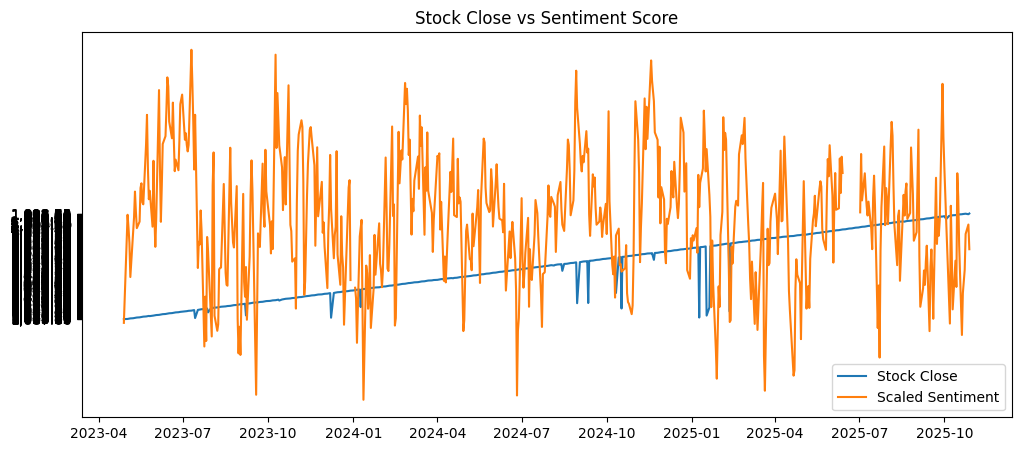

In [55]:
# Convert to datetime if not already done
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Filter data from 28-Apr-2023 onwards
merged_df = merged_df[merged_df['date'] >= '2023-04-28'].reset_index(drop=True)

print(merged_df.head())
print(merged_df.tail())
print("Final date range:", merged_df['date'].min(), "→", merged_df['date'].max())

# Check if any missing sentiment days remain
print(merged_df['final_sentiment'].isna().sum())

# Plot stock close vs sentiment
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(merged_df['date'], merged_df['close'], label='Stock Close')
plt.plot(merged_df['date'], merged_df['final_sentiment']*1000, label='Scaled Sentiment')
plt.legend()
plt.title('Stock Close vs Sentiment Score')
plt.show()


In [56]:

merged_df = merged_df.sort_values('date')  # ensure chronological order

merged_df['sentiment_3d_avg'] = merged_df['final_sentiment'].rolling(window=3).mean()
merged_df['sentiment_7d_avg'] = merged_df['final_sentiment'].rolling(window=7).mean()
merged_df['sentiment_14d_avg'] = merged_df['final_sentiment'].rolling(window=14).mean()

# fill initial NaNs caused by rolling
merged_df.fillna(method='bfill', inplace=True)


C:\Users\jhanv\AppData\Local\Temp\ipykernel_16980\1786722046.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='bfill', inplace=True)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Create the target column (next day's close)
merged_df['target'] = merged_df['close'].shift(-1)

# Clean numeric columns: remove commas and convert to float
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
for col in numeric_cols:
    merged_df[col] = merged_df[col].astype(str).str.replace(',', '').astype(float)

# Define features
features = [
    'open', 'high', 'low', 'close', 'volume',
    'final_sentiment', 'sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_14d_avg'
]

# Scale feature columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df[features])

# Create scaled DataFrame and add target + date
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['target'] = merged_df['target']
scaled_df['date'] = merged_df['date']